# 4 - Deep learning on molecular fingerprints

There are a few different ways to go about QSAR. some of the key ones are:
- Molecular descriptors and classicalML algorithms
- Molceular descriptors and deep learning
- Various other encodings, one-hot, autoencoders, graphs and deep learning

We've discussed molecular descriptors and classicalML algorithms already. 
In this notebook we'll introduce a simple feed forward network, and see its performance in our HIV1 QSAR example data. 

This isn't meant to be any sort of introduction to deep learning, I'll assume you're clued in.


### Preprocessing

This follows the previous data loading, cleaning and descriptor generation you've seen already.

In [8]:
# general
import os
from multiprocessing import Pool
import random

# data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# cheminformatics
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
import deepchem as dc

# rather than have all that code to import the hiv data let's use this helper function
from lib import helper
df = helper.import_data()
df = df[0:200]
y = df['pKi']

In [9]:
def smiles_2_ecfp4(smiles):
    mol = Chem.MolFromSmiles(smiles)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol,4,nBits=1024,useFeatures=True)
    arr = np.zeros((1,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return(arr)

with Pool(processes=os.cpu_count()) as p:
    x_ecfp4 = np.stack(p.map(smiles_2_ecfp4, df.smiles.values))

### A basic feed forward neural network QSAR model

Neural networks can be as simple as a single neuron that takes an input and produces an output, but that's not terribly interesting. Deep learning is really all about using many layers that feed into each other.

The idea is that these networks when made sufficiently complex, and given adequate input data and training parameeters should be able to represent any mathematical function. Many layers allows the netowrk to learn more complex relationships than an of the previous classicML algorithms we've already tried out.

The caveat is just that, if you have poor quantity or quality of data, you may spend forever training a network, only for linear regression to outcompete it. They can be at risk of over-fitting, much more so that many other simpler algorithms. 

Let's jump in to the feed forward example, here we use keras and tensorflow, other frameworksa are available such as pytorch. 

In [10]:
# keras is part of the tensorflow package, a nice API to build models
import tensorflow as tf
from sklearn.metrics import r2_score, mean_squared_error
from tensorflow.keras.optimizers import SGD
#from keras.models import Sequential
#from keras.layers import Dense, Activation
#from keras.optimizers import SGD
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split

# we need to bind the predicted value between 0-1, as this is the output neuron's limited values
# in future we could then rescale the output to match the meaningful pki values.
Y = normalize([np.array(y)])
# x_ecfp4 is already binary making our life easy
x_train, x_test, y_train, y_test = train_test_split(x_ecfp4, y, test_size=0.3, random_state=42)

In [11]:
# build tf model via keras API. 
# This is a simple model, with an input layer, a single deep layer, and an output 
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(64, input_shape=(x_train.shape[1],)))
model.add(tf.keras.layers.Dense(units=64, activation='relu'))
model.add(tf.keras.layers.Dense(units=1))


# fit, metrics, tracking
model.compile(loss='mean_squared_error', optimizer=SGD(learning_rate=0.01, momentum=0.2, nesterov=True))
history = model.fit(x_train, y_train, epochs=50, batch_size=64)

Epoch 1/50
3/3 [==============================] - 5s 56ms/step - loss: 10.8243
Epoch 2/50
3/3 [==============================] - 0s 19ms/step - loss: 7.9565
Epoch 3/50
3/3 [==============================] - 0s 18ms/step - loss: 4.9024
Epoch 4/50
3/3 [==============================] - 0s 44ms/step - loss: 4.1881
Epoch 5/50
3/3 [==============================] - 0s 7ms/step - loss: 3.8190
Epoch 6/50
3/3 [==============================] - 0s 19ms/step - loss: 3.3471
Epoch 7/50
3/3 [==============================] - 0s 9ms/step - loss: 3.2812
Epoch 8/50
3/3 [==============================] - 0s 16ms/step - loss: 4.6239
Epoch 9/50
3/3 [==============================] - 0s 32ms/step - loss: 5.4181
Epoch 10/50
3/3 [==============================] - 0s 16ms/step - loss: 2.9351
Epoch 11/50
3/3 [==============================] - 0s 13ms/step - loss: 5.9654
Epoch 12/50
3/3 [==============================] - 0s 28ms/step - loss: 2.6091
Epoch 13/50
3/3 [==============================] - 0s 16ms/ste

great we trained a model, how well can it predict the unseen test set?

In [12]:
test_preds = model.predict(x_test)
rmse = mean_squared_error(y_test, test_preds)
r2 = r2_score(y_test, test_preds)
#s = np.std(y_test -y_pred)
print("Neural Network RMS:", rmse, " - R2:",r2)

2/2 [==============================] - 0s 10ms/step
Neural Network RMS: 3.0835976645184404  - R2: 0.6283634125954443


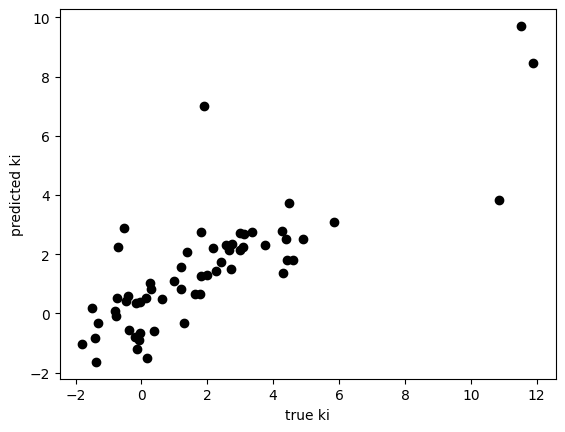

In [13]:
# remember, always plot.
plt.plot(y_test, test_preds, 'o', color='black');
plt.xlabel('true ki');
plt.ylabel('predicted ki');

whoa! see, even this simple neural network model is already an outright winner! You can see why deep learning has gained so much interest in general and in the QSAR community.

As we are only dealing with one set of descriptors here, let's see how well we can predict using all the available data! Let's also tweak the nnet slightly to show you how it's done.


In [14]:
df = helper.import_data()
y = df['pKi']

def smiles_2_ecfp4(smiles):
    mol = Chem.MolFromSmiles(smiles)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol,4,nBits=1024,useFeatures=True)
    arr = np.zeros((1,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return(arr)

with Pool(processes=os.cpu_count()) as p:
    x_ecfp4 = np.stack(p.map(smiles_2_ecfp4, df.smiles.values))

Y = normalize([np.array(y)])

x_train, x_test, y_train, y_test = train_test_split(x_ecfp4, y, test_size=0.3, random_state=42)

In [15]:
# build tf model via keras API
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(128, input_shape=(x_train.shape[1],)))
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
tf.keras.layers.Dropout(.1, input_shape=(128,))
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dense(units=1))


# fit, metrics, tracking
model.compile(loss='mean_squared_error', optimizer=SGD())
history = model.fit(x_train, y_train, epochs=100, batch_size=64)
test_preds = model.predict(x_test)
rmse = mean_squared_error(y_test, test_preds)
r2 = r2_score(y_test, test_preds)
#s = np.std(y_test -y_pred)
print("Neural Network RMS:", rmse, " - R2:",r2)

Epoch 1/100
28/28 [==============================] - 2s 12ms/step - loss: 5.5473
Epoch 2/100
28/28 [==============================] - 0s 11ms/step - loss: 3.3592
Epoch 3/100
28/28 [==============================] - 0s 15ms/step - loss: 3.0435
Epoch 4/100
28/28 [==============================] - 0s 14ms/step - loss: 2.4926
Epoch 5/100
28/28 [==============================] - 0s 9ms/step - loss: 2.2967
Epoch 6/100
28/28 [==============================] - 0s 8ms/step - loss: 2.1963
Epoch 7/100
28/28 [==============================] - 0s 12ms/step - loss: 2.2222
Epoch 8/100
28/28 [==============================] - 0s 18ms/step - loss: 1.7215
Epoch 9/100
28/28 [==============================] - 0s 12ms/step - loss: 1.6185
Epoch 10/100
28/28 [==============================] - 0s 14ms/step - loss: 1.6274
Epoch 11/100
28/28 [==============================] - 0s 13ms/step - loss: 1.6256
Epoch 12/100
28/28 [==============================] - 0s 14ms/step - loss: 1.3611
Epoch 13/100
28/28 [=======

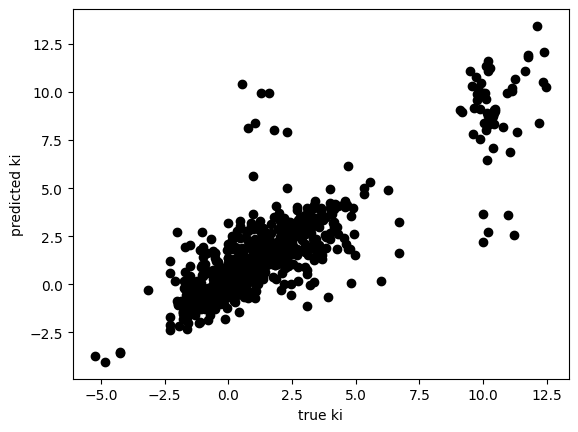

In [16]:
plt.plot(y_test, test_preds, 'o', color='black');
plt.xlabel('true ki');
plt.ylabel('predicted ki');

This model looks pretty good, not perfect though. Can you find any improvements?